<a href="https://colab.research.google.com/github/taroshg/pix2pix/blob/main/pix2pix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn

In [ ]:
class ReduceBlock(nn.Module):
    def __init__(self, in_chan, out_chan):
        super().__init__()
        self.conv = nn.Conv2d(in_chan, out_chan, kernel_size=4, stride=2, padding=1, bias=False, padding_mode='reflect')
        self.bn = nn.BatchNorm2d(out_chan)
        self.act = nn.LeakyReLU(0.2)
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.act(x)
        return x

In [ ]:
inp = torch.randn(1, 3, 10, 10)
reduceBlock = ReduceBlock(3, 64)
out = reduceBlock(inp)
print(out.shape)

torch.Size([1, 64, 5, 5])


In [ ]:
class ExpandBlock(nn.Module):
    def __init__(self, in_chan, out_chan):
        super().__init__()
        self.upconv = nn.ConvTranspose2d(in_chan, out_chan, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn = nn.BatchNorm2d(out_chan)
        self.act = nn.ReLU()
    def forward(self, x):
        x = self.upconv(x)
        x = self.bn(x)
        x = self.act(x)
        return x

In [ ]:
inp = torch.randn(1, 64, 5, 5)
expandBlock = ExpandBlock(64, 3)
out = expandBlock(inp)
print(out.shape)

torch.Size([1, 3, 10, 10])


In [ ]:
from torch import functional
class Generator(nn.Module):
    def __init__(self, in_chan=3, features=64):
        super().__init__()
        self.down0 = nn.Sequential(
            nn.Conv2d(in_chan, features, kernel_size=4, stride=2, padding=1, padding_mode='reflect'),
            nn.LeakyReLU(0.2)
        ) # features: 3 => 64 image: 256 => 128
        self.down1 = ReduceBlock(features, features * 2) # features: 64 => 128 image: 128 => 64
        self.down2 = ReduceBlock(features * 2, features * 4) # features: 128 => 256 image: 64 => 32
        self.down3 = ReduceBlock(features * 4, features * 8) # features: 256 => 512 image: 32 => 16
        self.down4 = ReduceBlock(features * 8, features * 8) # features: 512 => 512 image: 16 => 8
        self.down5 = ReduceBlock(features * 8, features * 8) # features: 512 => 512 image: 8 => 4
        self.down6 = ReduceBlock(features * 8, features * 8) # features: 512 => 512 image: 4 => 2

        self.bottleneck = nn.Sequential(
            nn.Conv2d(features * 8, features * 8, kernel_size=4, stride=2, padding=1),
            nn.ReLU()
        ) # features: 512 => 512 image: 2 => 1

        self.up1 = ExpandBlock(features * 8, features * 8) # features: 512 => 512 image: 1 => 2
        self.up2 = ExpandBlock(features * 8 * 2, features * 8) # features: 512 + 512 => 512 image: 2 => 4
        self.up3 = ExpandBlock(features * 8 * 2, features * 8) # features: 512 + 512 => 512 image: 4 => 8
        self.up4 = ExpandBlock(features * 8 * 2, features * 8) # features: 512 + 512 => 512 image: 8 => 16
        self.up5 = ExpandBlock(features * 8 * 2, features * 4) # features: 512 + 512 => 256 image: 16 => 32
        self.up6 = ExpandBlock(features * 4 * 2, features * 2) # features: 256 + 256 => 128 image: 32 => 64
        self.up7 = ExpandBlock(features * 2 * 2, features) # features: 128 + 128 => 64 image: 64 => 128

        self.final = nn.Sequential(
            nn.ConvTranspose2d(features, in_chan, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        ) # features: 64 => 3 image: 128 => 256

    def forward(self, x):
        d0 = self.down0(x)
        d1 = self.down1(d0)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        bneck = self.bottleneck(d6)
        u1 = self.up1(bneck)
        u2 = self.up2(torch.cat([u1, d6], dim=1))
        u3 = self.up3(torch.cat([u2, d5], dim=1))
        u4 = self.up4(torch.cat([u3, d4], dim=1))
        u5 = self.up5(torch.cat([u4, d3], dim=1))
        u6 = self.up6(torch.cat([u5, d2], dim=1))
        u7 = self.up7(torch.cat([u6, d1], dim=1))
        fin = self.final(u7)
        return fin

In [ ]:
inp = torch.randn(1, 3, 256, 256)
gen = Generator()
out = gen(inp)
print(out.shape)
assert inp.shape == out.shape

torch.Size([1, 3, 256, 256])


In [ ]:
class DiscBlock(nn.Module):
    def __init__(self, in_chan, out_chan, kernel_size=4, stride=2, padding=1, use_bn=True, use_act=True):
        super().__init__()
        self.use_bn = use_bn
        self.use_act = use_act
        self.conv = nn.Conv2d(in_chan, out_chan, kernel_size=4, stride=2, padding=1, bias=not use_bn, padding_mode='reflect')
        self.bn = nn.BatchNorm2d(out_chan)
        self.leakyRelu = nn.LeakyReLU(0.2)

    def forward(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.bn(x)
        if self.use_act:
            x = self.leakyRelu(x)
        return x

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, in_chan=3, features=64):
        super().__init__()
        self.conv0 = DiscBlock(in_chan * 2, features, use_bn=False) # features: 3 + 3 => 64 image: 256 => 128
        self.conv1 = DiscBlock(features, features * 2) # features: 64 => 128 image: 128 => 64
        self.conv2 = DiscBlock(features * 2, features * 4) # features: 128 => 256 image: 64 => 32
        self.conv3 = DiscBlock(features * 4, features * 8, stride=1, use_act=False) # features: 256 => 512 image: 32 => 16

    def forward(self, x, y):
        x = self.conv0(torch.cat([x, y], dim=1))
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        return x

In [ ]:
inp = torch.randn(1, 3, 256, 256)
real = torch.randn(1, 3, 256, 256)
disc = Discriminator()
out = disc(inp, real)
print(out.shape)

torch.Size([1, 512, 16, 16])


In [ ]:
!mkdir ~/.kaggle
!cp drive/MyDrive/machine-learning/kaggle.json ~/.kaggle/
!pip install -U -q kaggle==1.5.8
!chmod 600 ~/.kaggle/kaggle.json
!kaggle -v

     |████████████████████████████████| 59 kB 3.9 MB/s 
Kaggle API 1.5.8


In [ ]:
!kaggle datasets download -d vikramtiwari/pix2pix-dataset
!unzip pix2pix-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: edges2shoes/edges2shoes/train/8200_AB.jpg  
  inflating: edges2shoes/edges2shoes/train/8201_AB.jpg  
  inflating: edges2shoes/edges2shoes/train/8202_AB.jpg  
  inflating: edges2shoes/edges2shoes/train/8203_AB.jpg  
  inflating: edges2shoes/edges2shoes/train/8204_AB.jpg  
  inflating: edges2shoes/edges2shoes/train/8205_AB.jpg  
  inflating: edges2shoes/edges2shoes/train/8206_AB.jpg  
  inflating: edges2shoes/edges2shoes/train/8207_AB.jpg  
  inflating: edges2shoes/edges2shoes/train/8208_AB.jpg  
  inflating: edges2shoes/edges2shoes/train/8209_AB.jpg  
  inflating: edges2shoes/edges2shoes/train/820_AB.jpg  
  inflating: edges2shoes/edges2shoes/train/8210_AB.jpg  
  inflating: edges2shoes/edges2shoes/train/8211_AB.jpg  
  inflating: edges2shoes/edges2shoes/train/8212_AB.jpg  
  inflating: edges2shoes/edges2shoes/train/8213_AB.jpg  
  inflating: edges2shoes/edges2shoes/train/8214_AB.jpg  
  inflating: edges2shoes/edges2shoes/t

In [ ]:
from torch.utils.data import Dataset
from PIL import Image
import numpy as np
import os

# https://www.kaggle.com/vikramtiwari/pix2pix-dataset
class Data(Dataset):
    def __init__(self, folder, x_transform=None, y_transfrom=None):
        super().__init__()
        self.x_transform = x_transform
        self.y_transform = y_transfrom
        self.path = os.path.join(folder, folder, 'train')
        self.images = os.listdir(self.path)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = os.path.join(self.path, self.images[idx])
        img = np.array(Image.open(img))
        cut = (img.shape[1] // 2)
        x = img[:, :cut, :]
        y = img[:, cut:, :]

        if self.x_transform:
            x = self.x_transform(x)
        if self.y_transform:
            y = self.y_transform(y)

        return x, y

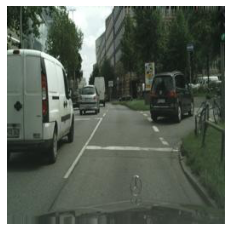

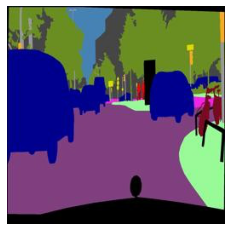

In [ ]:
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

img_size = 256

transform = transforms.Compose([
    transforms.ToTensor(),   
    transforms.Resize(img_size),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])                             
])

batch_size = 16

cityscapes = Data('cityscapes', transform, transform)
dataloader = DataLoader(dataset=cityscapes, batch_size=batch_size, shuffle=True)

for x, y in cityscapes:
    plt.imshow(((x * 0.5) + 0.5).permute(1, 2, 0))
    plt.axis('off')
    plt.show()
    
    plt.imshow(((y * 0.5) + 0.5).permute(1, 2, 0))
    plt.axis('off')
    plt.show()
    break

In [ ]:
from torch import optim

device = 'cpu'
learning_rate = 2e-4

gen = Generator(in_chan=3).to(device)
gen_optim = optim.Adam(gen.parameters(), lr=learning_rate, betas=(0.5, 0.999))

disc = Discriminator(in_chan=3).to(device)
disc_optim = optim.Adam(disc.parameters(), lr=learning_rate, betas=(0.5, 0.999))

bce = nn.BCEWithLogitsLoss()
L1 = nn.L1Loss()

  0%|          | 0/186 [00:00<?, ?it/s]

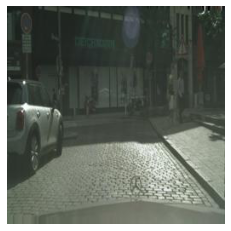

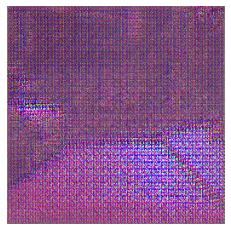

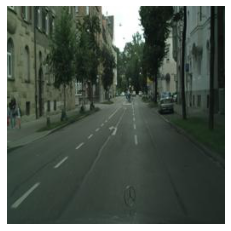

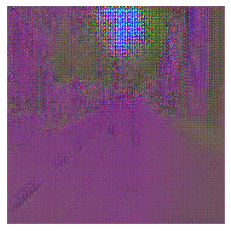

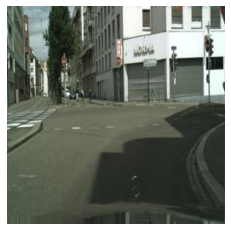

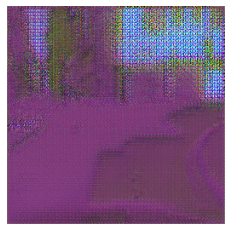

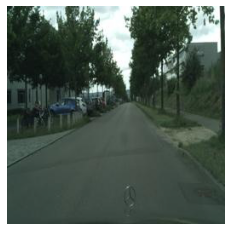

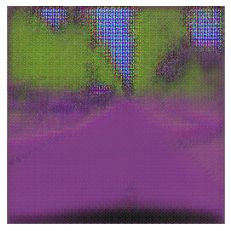

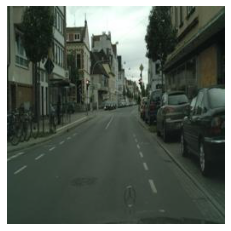

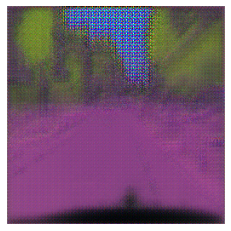

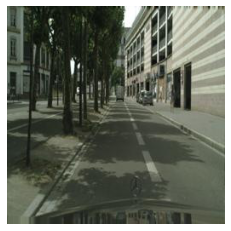

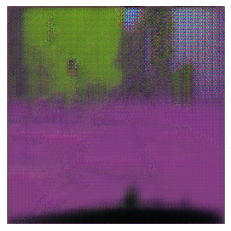

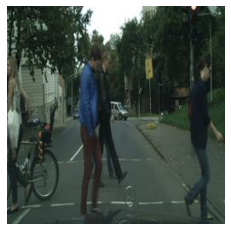

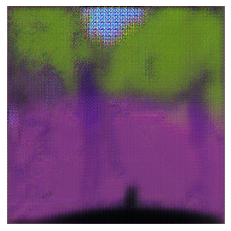

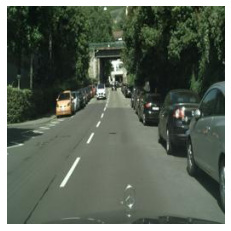

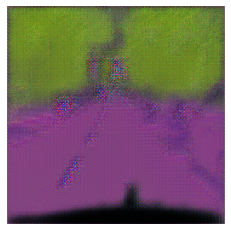

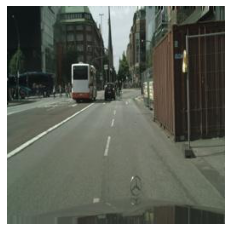

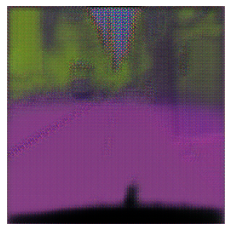

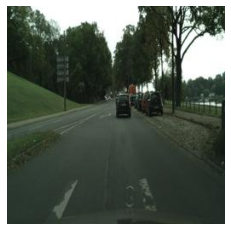

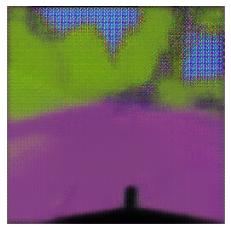

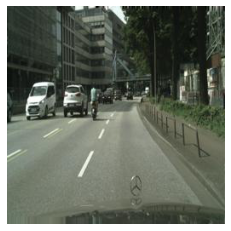

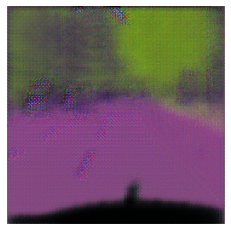

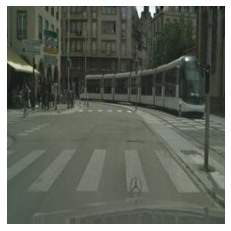

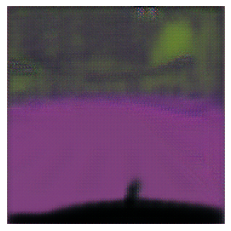

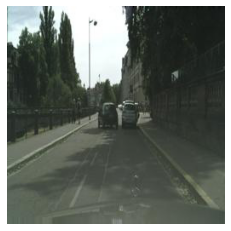

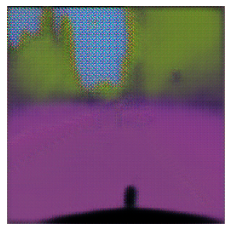

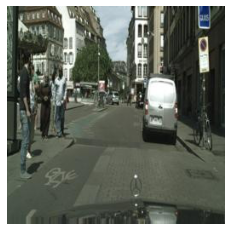

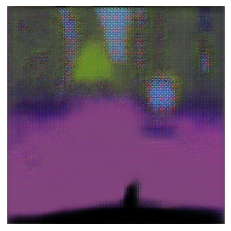

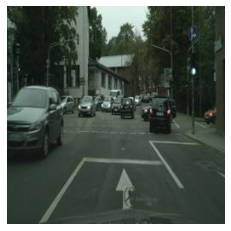

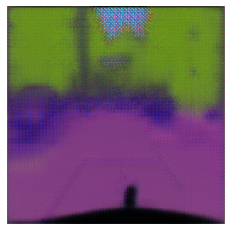

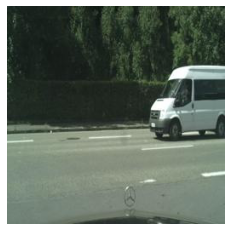

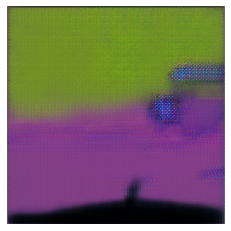

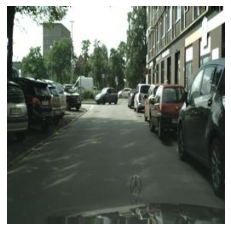

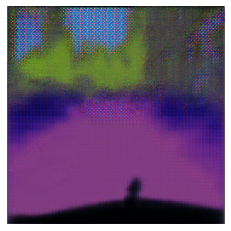

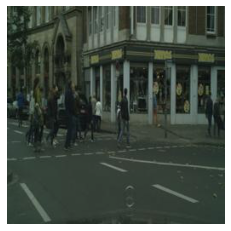

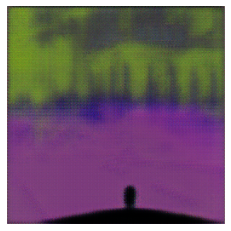

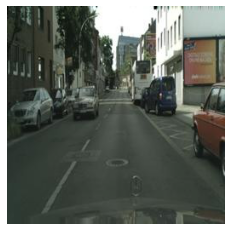

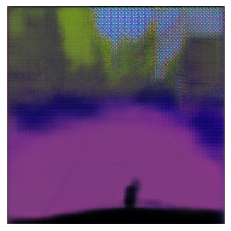

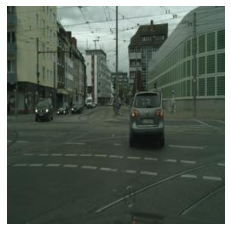

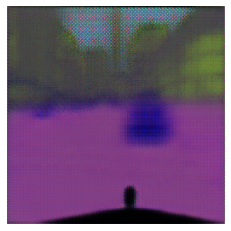

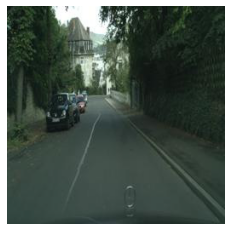

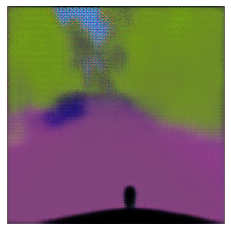

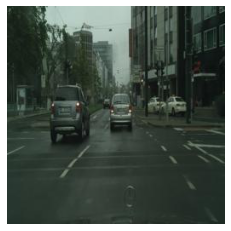

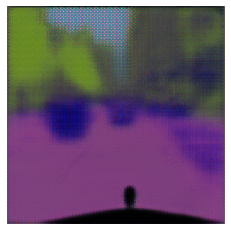

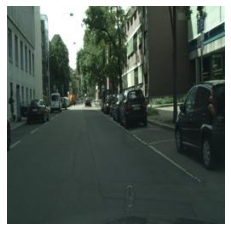

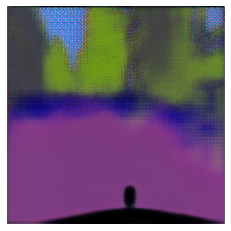

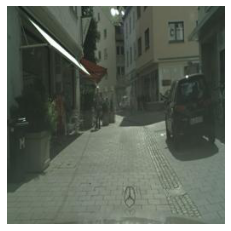

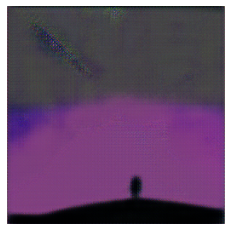

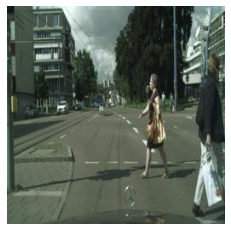

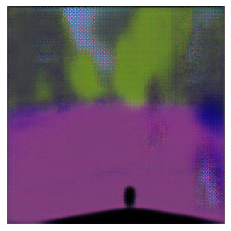

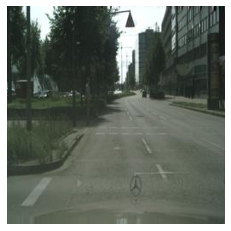

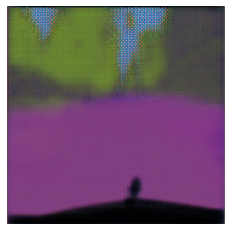

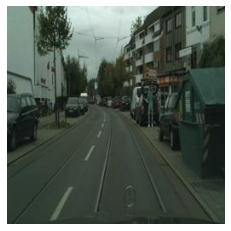

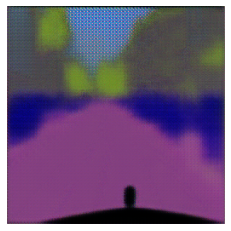

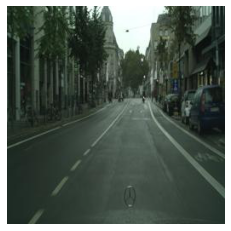

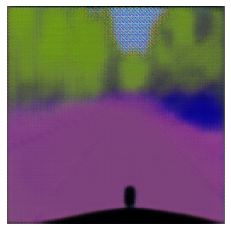

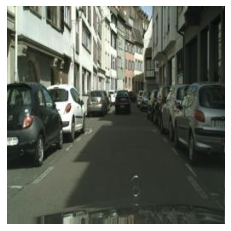

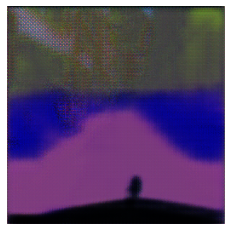

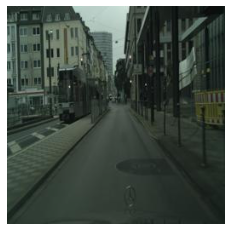

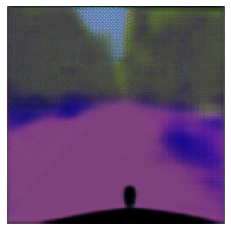

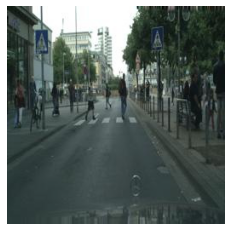

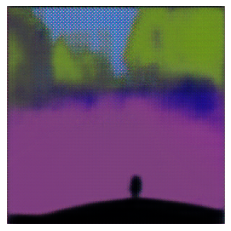

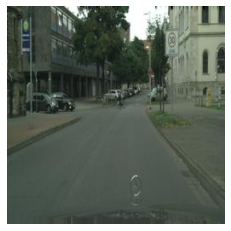

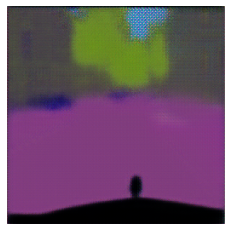

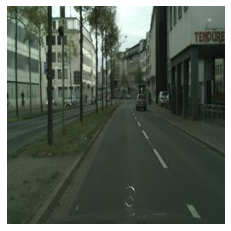

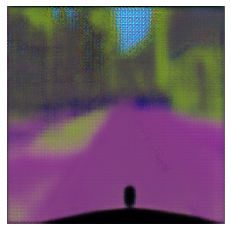

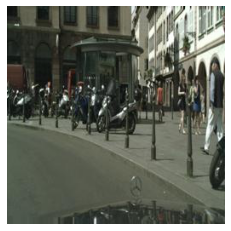

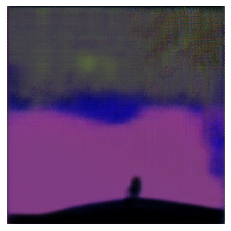

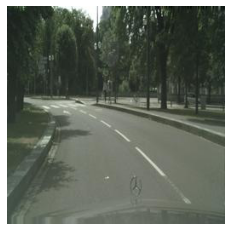

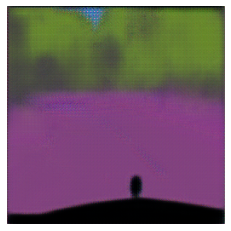

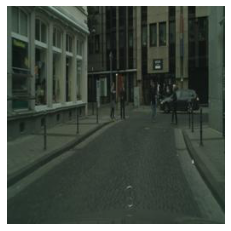

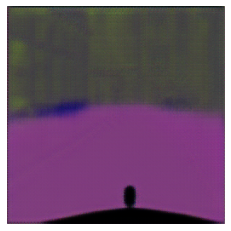

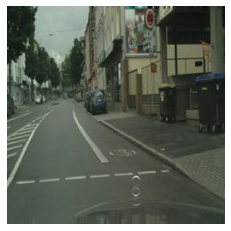

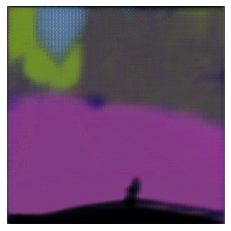

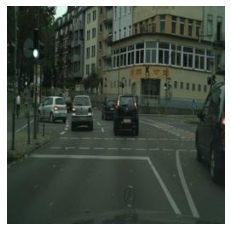

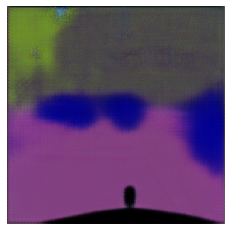

In [ ]:
from tqdm.auto import tqdm

epochs = 1

L1_lambda = 100
count = 0

for epoch in range(epochs):
    for x, y in tqdm(dataloader):
        generated_y = gen(x)

        # update discriminator
        pred_real = disc(x, y)
        pred_fake = disc(x, generated_y.detach())

        loss_real = bce(pred_real, torch.ones_like(pred_real))
        loss_fake = bce(pred_fake, torch.ones_like(pred_fake))

        loss = (loss_real + loss_fake) / 2

        disc.zero_grad()
        loss.backward()
        disc_optim.step()

        # update generator
        pred_fake = disc(x, generated_y)
        loss_fake = bce(pred_fake, torch.ones_like(pred_fake))
        loss_L1 = L1_lambda * L1(y, generated_y)

        loss = loss_fake + loss_L1

        gen.zero_grad()
        loss.backward()
        gen_optim.step()

        if count % 5 == 0:
            disp_x = x[0].permute(1, 2, 0).detach().cpu().numpy()
            disp_x = (disp_x * 0.5) + 0.5
            plt.imshow(disp_x)
            plt.axis('off')
            plt.show()

            disp_generated_y = generated_y[0].permute(1, 2, 0).detach().cpu().numpy()
            disp_generated_y = (disp_generated_y * 0.5) + 0.5
            plt.imshow(disp_generated_y)
            plt.axis('off')
            plt.show()

        count += 1